In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import kerastuner
import tensorflow
import seaborn as sns
import pandas as pd

from tensorflow import keras

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors

from sklearn import datasets, metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler


from scipy import interp
from tensorflow.keras.layers import Embedding, Dense 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from kerastuner.tuners import BayesianOptimization

from tensorflow.keras import backend as K 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers

C:\Users\lab\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  after removing the cwd from sys.path.


In [3]:
inp = pd.read_csv('Total_dataset.csv')
inp

,smiles,toxicity,ref
0,CC1=NN=C(O1)C(=O)NC(C)(C)C2=N/C(=C(/NCC3=CC=C(...,1,DILIrank
1,C1=CC2=C(C=C1OC(F)(F)F)SC(=N2)N,1,DILIrank
2,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,1,DILIrank
3,CC(C1=CC(=CC=C1)OC2=CC=CC=C2)C(=O)O,1,DILIrank
4,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,1,DILIrank
...,...,...,...
1845,c1ccc(cc1)CC2C(=O)NC(C(=O)NC(C(=O)NC(CSSCCC(=O...,0,Liew
1846,CC1C(C(CC(O1)OC2CCC3(C(C2)CCC4C3CC(C5(C4(CCC5C...,0,Liew
1847,COc1cc(cc(c1OC)OC)C(=O)OC2CC3CN4CCc5c6ccccc6[n...,0,Liew
1848,CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...,0,Liew


In [4]:
inp.groupby('toxicity')['ref'].value_counts()

toxicity  ref     
0         Liew        337
          DILIrank    268
          NCTR        179
          Greene       80
          Xu           34
1         Liew        438
          DILIrank    184
          NCTR        169
          Greene      149
          Xu           12
Name: ref, dtype: int64

In [5]:
train_df = inp.iloc[452:,:].reset_index(drop=True)
train_df

,smiles,toxicity,ref
0,CC(Cc1ccc(c(c1)O)O)(C(=O)O)N,1,NCTR
1,Cc1c(c2ccc(cc2n1CC(=O)O)OC)C(=O)c3ccc(cc3)Cl,1,NCTR
2,CN1C(S(=O)(=O)CCC1=O)c2ccc(cc2)Cl,1,NCTR
3,CC(=O)OC1C(Sc2ccccc2N(C1=O)CCN(C)C)c3ccc(cc3)OC,1,NCTR
4,c1nc2c(n1C3CC(C(O3)CO)O)NC=NCC2O,1,NCTR
...,...,...,...
1393,c1ccc(cc1)CC2C(=O)NC(C(=O)NC(C(=O)NC(CSSCCC(=O...,0,Liew
1394,CC1C(C(CC(O1)OC2CCC3(C(C2)CCC4C3CC(C5(C4(CCC5C...,0,Liew
1395,COc1cc(cc(c1OC)OC)C(=O)OC2CC3CN4CCc5c6ccccc6[n...,0,Liew
1396,CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...,0,Liew


In [6]:
test_df = inp.iloc[:452,:]
test_df

,smiles,toxicity,ref
0,CC1=NN=C(O1)C(=O)NC(C)(C)C2=N/C(=C(/NCC3=CC=C(...,1,DILIrank
1,C1=CC2=C(C=C1OC(F)(F)F)SC(=N2)N,1,DILIrank
2,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,1,DILIrank
3,CC(C1=CC(=CC=C1)OC2=CC=CC=C2)C(=O)O,1,DILIrank
4,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,1,DILIrank
...,...,...,...
447,C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C...,0,DILIrank
448,CN1[C@H](CNC2=C1C(=O)N=C(N2)N)CNC3=CC=C(C=C3)C...,0,DILIrank
449,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,0,DILIrank
450,C[C@@H]1[C@H]([C@@H]([C@@H](C(O1)OC\2CC(C(C(CC...,0,DILIrank


In [7]:
train_s = train_df.iloc[:,:-1]
train_t = train_df['toxicity']
test_s = test_df.iloc[:,:-1]
test_t = test_df['toxicity']

In [8]:
# smiles 
smiles_list = []
for i in range(len(train_df)):
    train_df['smiles'][i] = str(train_df['smiles'][i])

# mol 형태로 변환
mols = [Chem.MolFromSmiles(smiles) for smiles in train_df["smiles"]]

# mol 형태로 변환이 되지 않은 경우, none_list에
none_list = []
for i in range(len(mols)):
    if mols[i] is None :
        none_list.append(i)
        print('none_list에 추가됨')
    
reg_idx = 0
for i in none_list :
    del mols[i - reg_idx]
    reg_idx += 1
    
# 데이터프레임 인덱스 맞춰주기
if len(none_list) != 0 :
    train_df = train_df.drop(none_list, axis=0)
    train_df = train_df.reset_index(drop = True)

C:\Users\lab\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
train_df['toxicity'].value_counts()

1    768
0    630
Name: toxicity, dtype: int64

In [10]:
# fingerprint 생성
bit_info_list = [] # bit vector의 설명자 리스트 담기
bit_info = {} #bit vector 설명자
fps = []

b = 0

# mol 파일에서 fingerprint Bit Vector 형태로 변환하기
for a in mols :
    fps.append(AllChem.GetMorganFingerprintAsBitVect(a, 3, nBits = 1024, bitInfo = bit_info))
    bit_info_list.append(bit_info.copy()) # bit_info 그대로 가져오면 변수가 변해서 리스트 값이 달라지므로 .copy()
    
# array 변환
arr_list = list()
for i in range(len(fps)):
    array = np.zeros((0,), dtype = np.int8)
    arr_list.append(array)
    
for i in range(len(fps)):
    bit = fps[i]
    DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    
x = np.stack([i.tolist() for i in arr_list])
x = x.astype(np.float32)
finprt = pd.DataFrame(x)

In [11]:
# QED properties 구하기

from rdkit.Chem import QED

qe = [QED.properties(mol) for mol in mols]
qe = pd.DataFrame(qe)
qe

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,211.217,0.44230,5,4,103.78,3,1,1
1,357.793,3.92732,4,1,68.53,5,3,1
2,273.741,1.61550,3,0,54.45,1,1,0
3,414.527,3.36850,6,0,59.08,6,2,1
4,268.273,-0.98900,6,4,112.13,2,1,0
...,...,...,...,...,...,...,...,...
1393,1069.238,-4.34170,16,13,437.91,19,2,4
1394,943.090,0.04230,19,9,282.21,10,0,2
1395,578.662,4.16250,9,1,108.55,7,3,1
1396,556.792,6.76220,4,0,59.08,15,2,2


In [12]:
# #mol을 data frame 형태로 변환

# m = pd.DataFrame(mols)
# m.columns=['mol']

# from rdkit.Chem.Descriptors import qed

# #QED 계산

# qe['QED']= m.mol.apply(qed)

# #Oral Bioavailability 구하기 

# conditionlist = [
#     (qe['ROTB'] <= 10) & (qe['HBA']+qe['HBD']<=12),
#     (qe['ROTB'] <= 10) & (qe['PSA'] <= 140)]

# choicelist = ['1','1']

# qe['OB'] = np.select(conditionlist, choicelist, default = '0')
# qe

In [13]:

#QED datapreprocessing 
ss = StandardScaler()

ss.fit(qe)
qe_scaled = ss.transform(qe) 


qe_scaled = pd.DataFrame(qe_scaled)
qe_scaled.columns =['MW','ALOGP','HBA','HBD','PSA','ROTB','AROM','ALERTS']
qe_scaled

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,-0.769322,-0.669906,-0.019260,0.733783,0.213807,-0.463486,-0.413202,-0.009528
1,-0.022689,0.682270,-0.266282,-0.435030,-0.237935,-0.034662,1.403327,-0.009528
2,-0.450835,-0.214709,-0.513305,-0.824635,-0.418376,-0.892310,-0.413202,-0.897540
3,0.266304,0.465449,0.227762,-0.824635,-0.359040,0.179750,0.495062,-0.009528
4,-0.478688,-1.225246,0.227762,0.733783,0.320815,-0.677898,-0.413202,-0.897540
...,...,...,...,...,...,...,...,...
1393,3.601285,-2.526083,2.697986,4.240223,4.495807,2.967107,0.495062,2.654509
1394,2.958710,-0.825105,3.439053,2.681805,2.500453,1.037399,-1.321466,0.878484
1395,1.102378,0.773519,0.968830,-0.435030,0.274936,0.394162,1.403327,-0.009528
1396,0.990976,1.782194,-0.266282,-0.824635,-0.359040,2.109459,0.495062,0.878484


In [14]:
from pickle import dump

#dump(ss, open('./standard_scaler.pkl','wb'))

In [15]:
final = pd.concat([finprt,qe_scaled,train_t],axis=1)
final

,0,1,2,3,4,5,6,7,8,9,...,1023,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,toxicity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.769322,-0.669906,-0.019260,0.733783,0.213807,-0.463486,-0.413202,-0.009528,1
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,-0.022689,0.682270,-0.266282,-0.435030,-0.237935,-0.034662,1.403327,-0.009528,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.450835,-0.214709,-0.513305,-0.824635,-0.418376,-0.892310,-0.413202,-0.897540,1
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.266304,0.465449,0.227762,-0.824635,-0.359040,0.179750,0.495062,-0.009528,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.478688,-1.225246,0.227762,0.733783,0.320815,-0.677898,-0.413202,-0.897540,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.601285,-2.526083,2.697986,4.240223,4.495807,2.967107,0.495062,2.654509,0
1394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.958710,-0.825105,3.439053,2.681805,2.500453,1.037399,-1.321466,0.878484,0
1395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.102378,0.773519,0.968830,-0.435030,0.274936,0.394162,1.403327,-0.009528,0
1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.990976,1.782194,-0.266282,-0.824635,-0.359040,2.109459,0.495062,0.878484,0


In [16]:
final.iloc[:,:1024]

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
x_train = final.iloc[:,:1032]
y_train = final['toxicity']

## Test 

In [18]:
# smiles 
smiles_list = []
for i in range(len(test_df)):
    test_df['smiles'][i] = str(test_df['smiles'][i])

# mol 형태로 변환
mols = [Chem.MolFromSmiles(smiles) for smiles in test_df["smiles"]]

# mol 형태로 변환이 되지 않은 경우, none_list에
none_list = []
for i in range(len(mols)):
    if mols[i] is None :
        none_list.append(i)
        print('none_list에 추가됨')
    
reg_idx = 0
for i in none_list :
    del mols[i - reg_idx]
    reg_idx += 1
    
# 데이터프레임 인덱스 맞춰주기
if len(none_list) != 0 :
    test_df = test_df.drop(none_list, axis=0)
    test_df = test_df.reset_index(drop = True)


# fingerprint 생성
bit_info_list = [] # bit vector의 설명자 리스트 담기
bit_info = {} #bit vector 설명자
fps = []

b = 0

# mol 파일에서 fingerprint Bit Vector 형태로 변환하기
for a in mols :
    fps.append(AllChem.GetMorganFingerprintAsBitVect(a, 3, nBits = 1024, bitInfo = bit_info))
    bit_info_list.append(bit_info.copy()) # bit_info 그대로 가져오면 변수가 변해서 리스트 값이 달라지므로 .copy()
    
# array 변환
arr_list = list()
for i in range(len(fps)):
    array = np.zeros((0,), dtype = np.int8)
    arr_list.append(array)
    
for i in range(len(fps)):
    bit = fps[i]
    DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    
x = np.stack([i.tolist() for i in arr_list])
x = x.astype(np.float32)
finprt = pd.DataFrame(x)

C:\Users\lab\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lab\anaconda3\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
# QED properties 구하기

from rdkit.Chem import QED

qe = [QED.properties(mol) for mol in mols]
qe = pd.DataFrame(qe)
qe

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,444.423,0.98202,8,3,150.02,6,2,3
1,234.202,2.77710,3,1,48.14,1,2,0
2,1202.635,3.26900,12,5,278.80,15,0,1
3,242.274,3.66700,3,1,46.53,4,2,0
4,222.251,-0.85610,5,2,115.04,2,1,1
...,...,...,...,...,...,...,...,...
447,473.446,-0.73110,11,7,219.84,10,2,1
448,497.525,-3.30790,11,5,208.43,9,2,1
449,527.526,1.02890,11,5,185.84,4,3,1
450,926.107,0.77830,18,12,327.45,3,0,1


In [24]:
from pickle import load 

#QED datapreprocessing 
load_ss = load(open('./standard_scaler.pkl','rb'))
qe_scaled = load_ss.transform(qe)
qe_scaled = pd.DataFrame(qe_scaled, columns=['MW','ALOGP','HBA','HBD','PSA','ROTB','AROM','ALERTS'])
qe_scaled

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,0.418589,-0.460497,0.721807,0.344178,0.806389,0.179750,0.495062,1.766496
1,-0.652240,0.235988,-0.513305,-0.435030,-0.499241,-0.892310,0.495062,-0.897540
2,4.280786,0.426844,1.709897,1.123387,2.456753,2.109459,-1.321466,-0.009528
3,-0.611123,0.581266,-0.513305,-0.435030,-0.519873,-0.249074,0.495062,-0.897540
4,-0.713116,-1.173681,-0.019260,-0.045426,0.358108,-0.677898,-0.413202,-0.009528
...,...,...,...,...,...,...,...,...
447,0.566427,-1.125182,1.462874,1.902596,1.701159,1.037399,0.495062,-0.009528
448,0.689081,-2.124972,1.462874,1.123387,1.554935,0.822986,0.495062,-0.009528
449,0.841900,-0.442308,1.462874,1.123387,1.265436,-0.249074,1.403327,-0.009528
450,2.872202,-0.539540,3.192031,3.850618,3.080221,-0.463486,-1.321466,-0.009528


In [18]:

#QED datapreprocessing 
ss = StandardScaler()

ss.fit(qe)
qe_scaled = ss.transform(qe) 


qe_scaled = pd.DataFrame(qe_scaled)
qe_scaled.columns =['MW','ALOGP','HBA','HBD','PSA','ROTB','AROM','ALERTS']
qe_scaled

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,-0.031682,-0.078206,0.124693,-0.070660,0.065800,-0.124521,0.271724,1.806079
1,-0.372504,0.310100,-0.362862,-0.288668,-0.316390,-0.396949,0.271724,-0.882223
2,1.197573,0.416506,0.514738,0.147348,0.548903,0.365849,-1.181759,0.013878
3,-0.359417,0.502600,-0.362862,-0.288668,-0.322430,-0.233492,0.271724,-0.882223
4,-0.391879,-0.475822,-0.167840,-0.179664,-0.065423,-0.342464,-0.455017,0.013878
...,...,...,...,...,...,...,...,...
447,0.015372,-0.448783,0.417227,0.365357,0.327722,0.093421,0.271724,0.013878
448,0.054410,-1.006187,0.417227,0.147348,0.284919,0.038936,0.271724,0.013878
449,0.103049,-0.068065,0.417227,0.147348,0.200175,-0.233492,0.998466,0.013878
450,0.749251,-0.122274,1.099804,0.910377,0.731408,-0.287978,-1.181759,0.013878


In [19]:
final = pd.concat([finprt,qe_scaled,test_t],axis=1)
final

,0,1,2,3,4,5,6,7,8,9,...,1023,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,toxicity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.031682,-0.078206,0.124693,-0.070660,0.065800,-0.124521,0.271724,1.806079,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.372504,0.310100,-0.362862,-0.288668,-0.316390,-0.396949,0.271724,-0.882223,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.197573,0.416506,0.514738,0.147348,0.548903,0.365849,-1.181759,0.013878,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.359417,0.502600,-0.362862,-0.288668,-0.322430,-0.233492,0.271724,-0.882223,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.391879,-0.475822,-0.167840,-0.179664,-0.065423,-0.342464,-0.455017,0.013878,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.015372,-0.448783,0.417227,0.365357,0.327722,0.093421,0.271724,0.013878,0
448,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.054410,-1.006187,0.417227,0.147348,0.284919,0.038936,0.271724,0.013878,0
449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.103049,-0.068065,0.417227,0.147348,0.200175,-0.233492,0.998466,0.013878,0
450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.749251,-0.122274,1.099804,0.910377,0.731408,-0.287978,-1.181759,0.013878,0


In [20]:
x_test = final.iloc[:,:1032]
y_test = final['toxicity']

# x_test = np.asarray(x_test).astype('float32')
# y_test = np.asarray(y_test).astype('float32')

In [21]:
type(x_test.iloc[0,1025])

numpy.float64

In [22]:
x_test.iloc[0,1025]

-0.07820613953150202

## Train set

In [23]:
x = x_train
y = y_train

In [24]:
y.value_counts()

1    768
0    630
Name: toxicity, dtype: int64

In [25]:
# train validation set 나누기


x_train, x_val, y_train,y_val = train_test_split(x,y,train_size=0.8, random_state=42)


print(y_train.value_counts())
print(y_val.value_counts())

1    616
0    502
Name: toxicity, dtype: int64
1    152
0    128
Name: toxicity, dtype: int64


In [26]:
# # np.asarray astype
# x_train = np.asarray(x_train).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# x_val = np.asarray(x_val).astype('float32')
# y_val = np.asarray(y_val).astype('float32')

In [27]:
print(x_train.shape)
print(y_val.shape)

(1118, 1032)
(280,)


In [28]:
#성능평가를 위한 함수 정의

def populate_dict_with_module_objects(target_dict, modules, obj_filter):
      for module in modules:
        for name in dir(module):
          obj = getattr(module, name)
          if obj_filter(obj):
            target_dict[name] = obj


def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [ ]:
# input data의 차원 수
input_dim = x_train.shape[1]

# Layer weight initializers 설정 (가중치 초기화 설정)
initializer = tf.keras.initializers.HeNormal()


# L2 regularizer 설정
from tensorflow.keras import regularizers
regularizer = regularizers.l2(0.001)

#model hyperparameter
epochs = 100
batch_size = 32

#callbacks
callbacks = [
    tensorflow.keras.callbacks.ModelCheckpoint(
        "DILIattention.h5", save_best_only=True, monitor="val_loss"
    ),
    tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),
]

In [140]:
# PregTaboo
from keras.layers import Dense, Dropout, MultiHeadAttention
from keras import backend as K


# 모델 세부 설정
inputs = tf.keras.layers.Input(shape=(input_dim,))
dense_v = tf.keras.layers.Dense(input_dim, activation = None)(inputs)
attn_score = tf.keras.layers.Softmax(axis = -1)(dense_v)
cal_score = tf.math.multiply(inputs, attn_score)
Dense1 = tf.keras.layers.Dense(512, activation = 'relu', 
                          kernel_initializer = initializer)(cal_score)
Dense1_BN = tf.keras.layers.BatchNormalization()(Dense1)
Dropout = Dropout(rate=0.25)(Dense1_BN)
#Dense2 = tf.keras.layers.Dense(512, activation = 'relu', 
#                          kernel_initializer = initializer, kernel_regularizer=regularizer)(Dense1_BN)
#Dense2_BN = tf.keras.layers.BatchNormalization()(Dense2)
#Dense3 = tf.keras.layers.Dense(16, activation = 'relu', 
#                           kernel_initializer = initializer, kernel_regularizer=regularizer)(Dense2_BN)
#Dense3_BN = tf.keras.layers.BatchNormalization()(Dense3)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(Dropout)

In [141]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1032)]       0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1032)         1066056     input_11[0][0]                   
__________________________________________________________________________________________________
softmax_10 (Softmax)            (None, 1032)         0           dense_30[0][0]                   
__________________________________________________________________________________________________
tf.math.multiply_10 (TFOpLambda (None, 1032)         0           input_11[0][0]                   
                                                                 softmax_10[0][0]          

In [1]:
model.layer[3]

NameError: name 'model' is not defined

In [142]:
#model = tf.keras.Model(inputs=inputs, outputs=outputs)
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    )
    
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data = (x_val, y_val),
    callbacks = callbacks
    )

Epoch 1/100


C:\Users\lab\anaconda3\envs\my-rdkit-env\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


35/35 [==============================] - 1s 11ms/step - loss: 0.6845 - accuracy: 0.5492 - val_loss: 0.6892 - val_accuracy: 0.5429
Epoch 2/100
35/35 [==============================] - 0s 9ms/step - loss: 0.6011 - accuracy: 0.6959 - val_loss: 0.6843 - val_accuracy: 0.5429
Epoch 3/100
35/35 [==============================] - 0s 8ms/step - loss: 0.4184 - accuracy: 0.8041 - val_loss: 0.6796 - val_accuracy: 0.5500
Epoch 4/100
35/35 [==============================] - 0s 8ms/step - loss: 0.2649 - accuracy: 0.8828 - val_loss: 0.6703 - val_accuracy: 0.6000
Epoch 5/100
35/35 [==============================] - 0s 8ms/step - loss: 0.1877 - accuracy: 0.9177 - val_loss: 0.6719 - val_accuracy: 0.5607
Epoch 6/100
35/35 [==============================] - 0s 9ms/step - loss: 0.1071 - accuracy: 0.9678 - val_loss: 0.6620 - val_accuracy: 0.6107
Epoch 7/100
35/35 [==============================] - 0s 8ms/step - loss: 0.0799 - accuracy: 0.9705 - val_loss: 0.6632 - val_accuracy: 0.5964
Epoch 8/100
35/35 [=====

In [143]:
# 최적 모델 불러온 후 성능 확인
model.load_weights("DILIattention.h5")
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

15/15 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7743
Test accuracy 0.7743362784385681
Test loss 0.5559244155883789


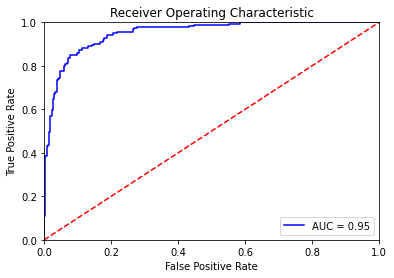

In [144]:
# ROC curve
from sklearn.metrics import roc_auc_score,roc_curve,auc
preds = model.predict(x_test)

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

roc = pd.DataFrame({
    'FPR': fpr,
    'TPRate': tpr,
    'Threshold': threshold
})

optimal_idx=np.argmax(tpr-fpr)
optimal_threshold= threshold[optimal_idx]


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [196]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# 테스트 셋에 대한 분류 수행 결과 및 점수
test_preds = model.predict(x_test)

test_preds[test_preds >= 0.5] = 1
test_preds[test_preds < 0.5] = 0

Precision = precision_score(y_test, test_preds)
Recall = recall_score(y_test, test_preds)

model_roc = model.predict(x_test)

print('accuracy : {0}'.format(accuracy_score(y_test, test_preds)))
print('Precision : {0}'.format(Precision))
print('Sensitivity : {0}'.format(Recall))
print('ROC_score : {0}'.format(roc_auc_score(y_test, model_roc)))

F1_score = 2*(Precision*Recall)/(Precision+Recall)
print("F1 score : {0}".format(F1_score))

accuracy : 0.7743362831858407
Precision : 0.6474820143884892
Sensitivity : 0.9782608695652174
ROC_score : 0.9511680726800779
F1 score : 0.7792207792207793


In [171]:
from sklearn.metrics import classification_report

print(classification_report(y_test,test_preds))

              precision    recall  f1-score   support

           0       0.98      0.63      0.77       268
           1       0.65      0.98      0.78       184

    accuracy                           0.77       452
   macro avg       0.81      0.81      0.77       452
weighted avg       0.84      0.77      0.77       452



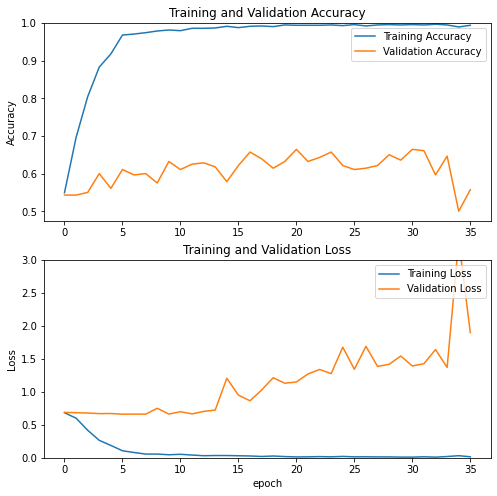

In [146]:
#Plotting 
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(acc, label='Training Accuracy') 
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='upper right') 
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1]) 
plt.title('Training and Validation Accuracy') 
plt.subplot(2, 1, 2) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right') 
plt.ylabel('Loss') 
plt.ylim([0,3.0]) 
plt.title('Training and Validation Loss') 
plt.xlabel('epoch') 
plt.show()

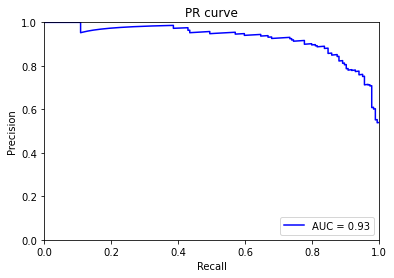

In [147]:
from sklearn.metrics import precision_recall_curve

# precision, recall, threshold 생성
precision, recall, thresholds = precision_recall_curve(y_test, preds)
# pr_auc 정의
pr_auc = auc(recall, precision)
# F1 score 정의
F1 = 2*(precision*recall)/(precision+recall)

plt.title('PR curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [148]:
d_t = pd.DataFrame(y_test)
d_t = d_t.reset_index(drop=True)
d_preds = pd.DataFrame(preds)
pred_proba = pd.concat([d_t,d_preds],axis=1)
pred_proba.columns=['toxicity','prediction']
pred_proba.sort_values(by='prediction',ascending=False)

,toxicity,prediction
414,0,0.216586
347,0,0.219898
318,0,0.230594
377,0,0.286647
328,0,0.287115
...,...,...
48,1,0.809897
77,1,0.813375
81,1,0.814167
26,1,0.841552


In [149]:
preds_1d = preds.flatten()
pred_class = np.where(preds_1d> optimal_threshold,1,0)

In [198]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

print('idx:',optimal_idx,', threshold:',optimal_threshold )

auc_score = roc_auc_score(y_test, preds)
accuracy_score = accuracy_score(y_test,pred_class)
Precision = precision_score(y_test,pred_class)
Recall = recall_score(y_test,pred_class)
print('AUC:',auc_score)
#print('ACC:',accuracy_score)
#print('Precision : {0}'.format(Precision))
#print('Recall : {0}'.format(Recall))
F1_score = 2*(Precision*Recall)/(Precision+Recall)
#print("F1 score : {0}".format(F1_score))

idx: 42 , threshold: 0.5802659
AUC: 0.9511680726800779


In [199]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# 테스트 셋에 대한 분류 수행 결과 및 점수
test_preds = model.predict(x_test)

test_preds[test_preds >= optimal_threshold] = 1
test_preds[test_preds < optimal_threshold] = 0

Precision = precision_score(y_test, test_preds)
Recall = recall_score(y_test, test_preds)

model_roc = model.predict(x_test)

print('accuracy : {0}'.format(accuracy_score(y_test, test_preds)))
print('Precision : {0}'.format(Precision))
print('Recall : {0}'.format(Recall))
print('ROC_score : {0}'.format(roc_auc_score(y_test, model_roc)))

F1_score = 2*(Precision*Recall)/(Precision+Recall)
print("F1 score : {0}".format(F1_score))

accuracy : 0.8871681415929203
Precision : 0.8518518518518519
Recall : 0.875
ROC_score : 0.9511680726800779
F1 score : 0.8632707774798928


In [200]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
specificity = tn / (tn+fp)
specificity

0.8955223880597015

In [178]:
name = pd.read_csv('test_DILIrank_raw.csv')
#test = test.drop(columns='name')
name = name.dropna().drop_duplicates().reset_index(drop=True)
name

,name,smiles,toxicity
0,raltegravir,CC1=NN=C(O1)C(=O)NC(C)(C)C2=N/C(=C(/NCC3=CC=C(...,1
1,riluzole,C1=CC2=C(C=C1OC(F)(F)F)SC(=N2)N,1
2,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,1
3,fenoprofen,CC(C1=CC(=CC=C1)OC2=CC=CC=C2)C(=O)O,1
4,acetazolamide,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,1
...,...,...,...
447,Levoleucovorin,C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C...,0
448,levomefolate calcium,CN1[C@H](CNC2=C1C(=O)N=C(N2)N)CNC3=CC=C(C=C3)C...,0
449,daunorubicin,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,0
450,nystatin,C[C@@H]1[C@H]([C@@H]([C@@H](C(O1)OC\2CC(C(C(CC...,0


In [191]:
preds = model.predict(x_test)
d_preds = pd.DataFrame(preds)
pred_proba = pd.concat([d_preds],axis=1)
pred_proba.columns=['prediction probability']
pred_proba

conditionlist = [
    (pred_proba['prediction probability'] < 0.58682096),
    (pred_proba['prediction probability'] >= 0.58682096)]

choicelist = ['0','1']

pred_proba['prediction toxicity'] = np.select(conditionlist, choicelist, default = '0')
pred_proba['toxicity'] = test_df['toxicity']
pred_proba['name'] = name['name']
pred_proba

,prediction probability,prediction toxicity,toxicity,name
0,0.614272,1,1,raltegravir
1,0.660608,1,1,riluzole
2,0.731730,1,1,cyclosporine
3,0.661503,1,1,fenoprofen
4,0.629478,1,1,acetazolamide
...,...,...,...,...
447,0.393459,0,0,Levoleucovorin
448,0.472514,0,0,levomefolate calcium
449,0.617755,1,0,daunorubicin
450,0.662778,1,0,nystatin


In [192]:
true_pos = pred_proba[(pred_proba['prediction toxicity'] == '1') & (pred_proba['toxicity'] == 1)]
true_pos

,prediction probability,prediction toxicity,toxicity,name
0,0.614272,1,1,raltegravir
1,0.660608,1,1,riluzole
2,0.731730,1,1,cyclosporine
3,0.661503,1,1,fenoprofen
4,0.629478,1,1,acetazolamide
...,...,...,...,...
177,0.734734,1,1,falnidamol
178,0.779343,1,1,aplaviroc
179,0.633959,1,1,pafuramidine
181,0.674534,1,1,eltrombopag olamine


In [153]:
history.history

{'loss': [0.684465229511261,
  0.6010634303092957,
  0.4183502793312073,
  0.2648923397064209,
  0.1876939982175827,
  0.10707557946443558,
  0.07987843453884125,
  0.056733060628175735,
  0.05669814348220825,
  0.04614371806383133,
  0.0531855970621109,
  0.04161737859249115,
  0.031702205538749695,
  0.034570448100566864,
  0.03455448895692825,
  0.030930722132325172,
  0.027682537212967873,
  0.020153556019067764,
  0.027106333523988724,
  0.01861393265426159,
  0.013432806357741356,
  0.014573189429938793,
  0.01818183995783329,
  0.014723377302289009,
  0.0209595188498497,
  0.014531814493238926,
  0.015226835384964943,
  0.013728837482631207,
  0.013503012247383595,
  0.010555511340498924,
  0.010113378055393696,
  0.015581405721604824,
  0.010063882917165756,
  0.019483882933855057,
  0.031715914607048035,
  0.015615766867995262],
 'accuracy': [0.5491949915885925,
  0.6958855390548706,
  0.8041144609451294,
  0.8828264474868774,
  0.9177101850509644,
  0.9677996635437012,
  0.97

In [158]:
# import pickle 

# with open('history.pickle','wb') as file_pi:
#     pickle.dump(history.history,file_pi)

In [159]:
with open('history.pickle','rb') as file_pi:
    history = pickle.load(file_pi)

In [160]:
history

{'loss': [0.684465229511261,
  0.6010634303092957,
  0.4183502793312073,
  0.2648923397064209,
  0.1876939982175827,
  0.10707557946443558,
  0.07987843453884125,
  0.056733060628175735,
  0.05669814348220825,
  0.04614371806383133,
  0.0531855970621109,
  0.04161737859249115,
  0.031702205538749695,
  0.034570448100566864,
  0.03455448895692825,
  0.030930722132325172,
  0.027682537212967873,
  0.020153556019067764,
  0.027106333523988724,
  0.01861393265426159,
  0.013432806357741356,
  0.014573189429938793,
  0.01818183995783329,
  0.014723377302289009,
  0.0209595188498497,
  0.014531814493238926,
  0.015226835384964943,
  0.013728837482631207,
  0.013503012247383595,
  0.010555511340498924,
  0.010113378055393696,
  0.015581405721604824,
  0.010063882917165756,
  0.019483882933855057,
  0.031715914607048035,
  0.015615766867995262],
 'accuracy': [0.5491949915885925,
  0.6958855390548706,
  0.8041144609451294,
  0.8828264474868774,
  0.9177101850509644,
  0.9677996635437012,
  0.97

In [162]:
hist_df = pd.DataFrame(history)
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.684465,0.549195,0.689196,0.542857
1,0.601063,0.695886,0.684287,0.542857
2,0.418350,0.804114,0.679615,0.550000
3,0.264892,0.882826,0.670311,0.600000
4,0.187694,0.917710,0.671932,0.560714
5,0.107076,0.967800,0.662036,0.610714
6,0.079878,0.970483,0.663164,0.596429
7,0.056733,0.974061,0.662843,0.600000
8,0.056698,0.978533,0.751595,0.575000
9,0.046144,0.981216,0.664143,0.632143


In [163]:
#hist_df.to_csv('history.csv',index=False)